In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('CGMData/cgm-19032024_123732.csv')
display(df)

,DeviceType,SerialNumber,Description,EventDateTime,Readings (CGM / BGM)
0,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:03,153
1,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:08,161
2,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:13,171
3,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:18,185
4,t:slim X2 Insulin Pump,1026835,EGV,3/5/2024 0:23,198
...,...,...,...,...,...
3972,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:36,400
3973,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:41,400
3974,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:46,400
3975,t:slim X2 Insulin Pump,1026835,EGV,3/18/2024 23:51,400


In [3]:
df = df.drop(columns=['SerialNumber', 'Description', 'DeviceType'])

# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['EventDateTime'], format='%m/%d/%Y %H:%M')

# Extract hour and minute features
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute

df = df.drop(columns=['EventDateTime'])

,Readings (CGM / BGM),DateTime,Hour,Minute,Eating,Activity Level,Carbohydrate Intake,Insulin Dosage
0,153,2024-03-05 00:03:00,0,3,No,Low,0,2.0
1,161,2024-03-05 00:08:00,0,8,No,Low,0,2.0
2,171,2024-03-05 00:13:00,0,13,No,Low,0,2.0
3,185,2024-03-05 00:18:00,0,18,No,Low,0,2.0
4,198,2024-03-05 00:23:00,0,23,No,Low,0,2.0
...,...,...,...,...,...,...,...,...
3972,400,2024-03-18 23:36:00,23,36,No,Low,0,2.4
3973,400,2024-03-18 23:41:00,23,41,No,Low,0,2.4
3974,400,2024-03-18 23:46:00,23,46,No,Low,0,2.4
3975,400,2024-03-18 23:51:00,23,51,No,Low,0,2.4


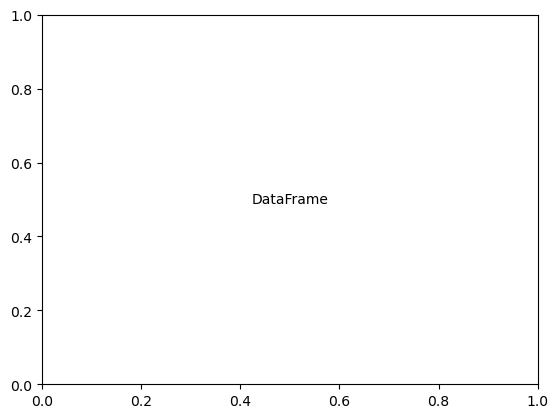

In [6]:
date_range = pd.date_range(start='2024-03-05 00:03:00', end='2024-03-18 23:56:00', freq='5T')

df['Eating'] = df['DateTime'].apply(lambda x: 'Yes' if (
    (pd.Timestamp(x).time() >= pd.Timestamp('09:30:00').time() and pd.Timestamp(x).time() <= pd.Timestamp('11:30:00').time()) or
    (pd.Timestamp(x).time() >= pd.Timestamp('14:00:00').time() and pd.Timestamp(x).time() <= pd.Timestamp('16:00:00').time()) or
    (pd.Timestamp(x).time() >= pd.Timestamp('21:00:00').time() and pd.Timestamp(x).time() <= pd.Timestamp('23:00:00').time())
) else 'No')

# Apply a lambda function to determine activity level
df['Activity Level'] = df['DateTime'].apply(lambda x: 'High' if (
    (pd.Timestamp(x).time() >= pd.Timestamp('18:00:00').time() and pd.Timestamp(x).time() <= pd.Timestamp('20:00:00').time()) and
    (pd.Timestamp(x).dayofweek in [6, 0, 2, 4])  # Sunday=6, Monday=0, Wednesday=2, Friday=4
) else 'Low')

df['Carbohydrate Intake'] = 0

# Define the time ranges and corresponding carb counts
time_ranges = [
    (pd.Timestamp('09:30:00').time(), pd.Timestamp('09:35:00').time(), 50),
    (pd.Timestamp('14:00:00').time(), pd.Timestamp('14:05:00').time(), 65),
    (pd.Timestamp('21:00:00').time(), pd.Timestamp('21:05:00').time(), 110)
]

# Set the 'Carbohydrate Intake' value for the specified time ranges and propagate for two hours
for start_time, end_time, carb_count in time_ranges:
    mask = (df['DateTime'].dt.time >= start_time) & (df['DateTime'].dt.time <= end_time)
    df.loc[mask, 'Carbohydrate Intake'] = carb_count

    # Propagate the 'Carbohydrate Intake' value for the next 24 time points after each specified time range
    for i in range(len(df)):
        if mask[i]:
            end_index = i + 24 if i + 24 < len(df) else len(df)
            df.loc[i:end_index, 'Carbohydrate Intake'] = carb_count
            

# Define the time ranges and corresponding basal rates
basal_rates = [
    (pd.Timestamp('00:00:00').time(), pd.Timestamp('03:00:00').time(), 2.0),
    (pd.Timestamp('03:00:00').time(), pd.Timestamp('08:00:00').time(), 1.8),
    (pd.Timestamp('08:00:00').time(), pd.Timestamp('21:00:00').time(), 2.4),
    (pd.Timestamp('21:00:00').time(), pd.Timestamp('00:00:00').time(), 2.2)
]

# Set the 'Insulin Dosage' value for the specified time ranges
for start_time, end_time, basal_rate in basal_rates:
    mask = (df['DateTime'].dt.time >= start_time) & (df['DateTime'].dt.time <= end_time)
    df.loc[mask, 'Insulin Dosage'] = basal_rate

# Apply the bolus for carbohydrate intake
df['Insulin Dosage'] += df['Carbohydrate Intake'] // 6  # Add 1 unit for every 6 carbs

# Forward fill the 'Insulin Dosage' column to propagate the values
df['Insulin Dosage'] = df['Insulin Dosage'].ffill()

display(df)

In [5]:
df.to_csv('CGMData/CGM_with_features.csv', index=False)